## Setup
Download dataset from Kaggle, import all necessary libraries, use CPU/GPU

In [1]:
# Setup and download the dataset
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
dataset_path += '/dataset'

print("Path to dataset files:", dataset_path)

100%|██████████| 587M/587M [00:10<00:00, 59.8MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models

import os
import sys
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report, roc_curve

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cpu


## Dataset preparation (PyTorch)
Transform images into PyTorch tensors and splits each weather class into 70-15-15 ratio

### Remove invalid images

In [6]:
# Some images are in GIF format
invalid_images = ['fogsmog/4514.jpg', 'snow/1187.jpg']

for filename in invalid_images:
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if the file exists
        os.remove(file_path)  # Remove the file
        print(f'Removed {file_path}')

Removed /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset/fogsmog/4514.jpg
Removed /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset/snow/1187.jpg


### Dataset statistics

Images count
rainbow   :  232
dew       :  698
rain      :  526
frost     :  475
glaze     :  639
fogsmog   :  850
rime      : 1160
sandstorm :  692
lightning :  377
hail      :  591
snow      :  620
Total: 11 classes with 6860 images


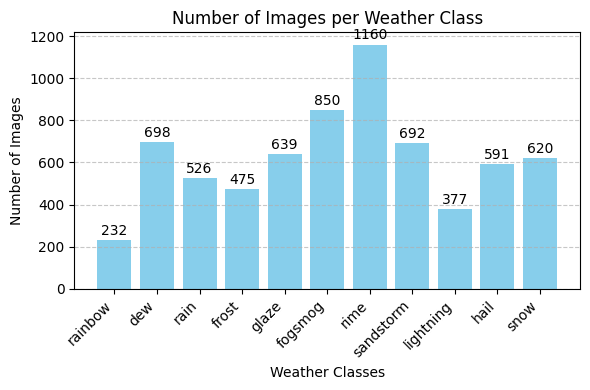

In [ ]:
classes = os.listdir(dataset_path)
num_classes = len(classes)

print("Images count")

total = 0
class_counts = []
for weather in classes:
  count = len(os.listdir(dataset_path+'/'+weather))
  total += count
  class_counts.append(count)
  print(f"{weather:9} : {count:4}")

print(f"Total: {num_classes} classes with {total} images")

plt.figure(figsize=(6, 4))
plt.bar(classes, class_counts, color='skyblue')
plt.xlabel('Weather Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Weather Class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

### Dataset visualization

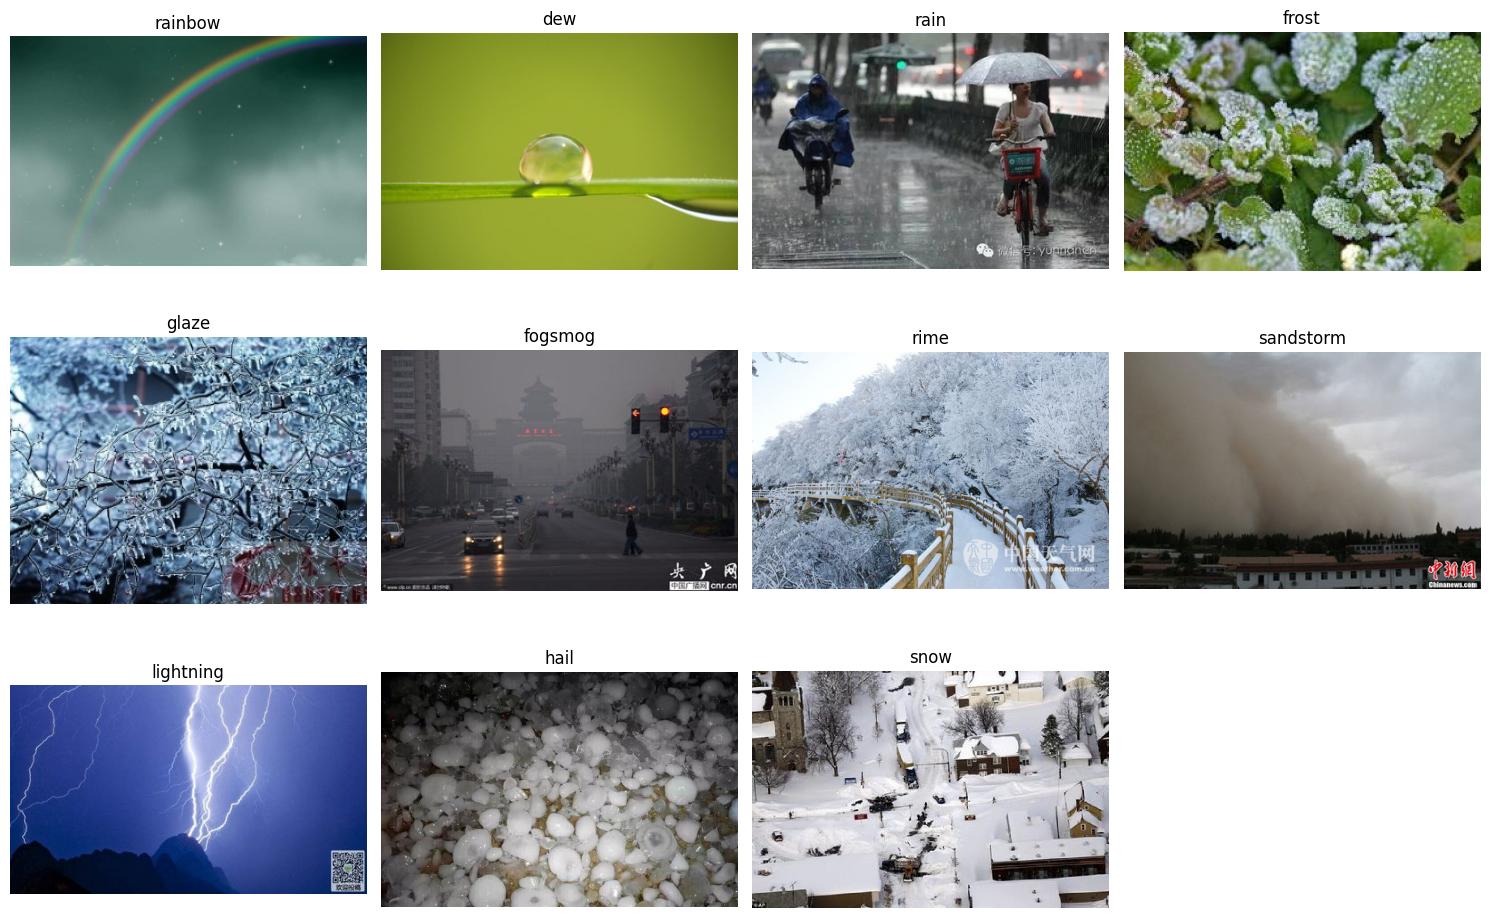

In [8]:
# Randomly show an image for each weather class
images_to_show = []
labels_to_show = []

for c in classes:
    folder_path = os.path.join(dataset_path, c)
    image_files = os.listdir(folder_path)
    random_image = random.choice(image_files)
    image_path = os.path.join(folder_path, random_image)

    image = Image.open(image_path)
    images_to_show.append(image)
    labels_to_show.append(c)

plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(zip(images_to_show, labels_to_show)):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns (adjust if >12 classes)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Transform datset to PyTorch tensors

In [ ]:
def split_dataset(altered_dataset, original_dataset, train_ratio=0.7, val_ratio=0.15, batch_size=64):
  num_workers = 2

  targets = np.array(altered_dataset.targets)

  # Split per class
  train_indices = []
  val_indices = []
  test_indices = []

  for class_idx in range(len(classes)):
    class_indices = np.where(targets == class_idx)[0]
    class_size = len(class_indices)

    train_size = int(train_ratio * class_size)
    val_size = int(val_ratio * class_size)

    train_idx, temp_idx = train_test_split(class_indices, train_size=train_size)
    val_idx, test_idx = train_test_split(temp_idx, train_size=val_size)

    train_indices.extend(train_idx)
    val_indices.extend(val_idx)
    test_indices.extend(test_idx)

  train_dataset = Subset(altered_dataset, train_indices)
  val_dataset = Subset(original_dataset, val_indices)
  test_dataset = Subset(original_dataset, test_indices)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  # print(f"Train set size: {len(train_dataset)}")
  # print(f"Validation set size: {len(val_dataset)}")
  # print(f"Test set size: {len(test_dataset)}")

  return train_loader, val_loader, test_loader

In [ ]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform_train = T.Compose([
    T.Resize((224, 224)), # for ResNet
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

transform_val_test = T.Compose([
    T.Resize((224, 224)), # for ResNet
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

altered_dataset = dset.ImageFolder(root=dataset_path, transform=transform_train)
original_dataset = dset.ImageFolder(root=dataset_path, transform=transform_val_test)

train_loader, val_loader, test_loader = split_dataset(altered_dataset, original_dataset, 0.8, 0.1, 128)

## Training
Use transfer learning with a pre-trained ResNet/EfficientNet model

In [3]:
def get_model():
  model = models.resnet18('DEFAULT')

  # Change the output layer to number of classes
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, num_classes)
  model.to(device)

  for param in model.parameters():
    param.requires_grad = False
  for param in model.fc.parameters(): # ResNet
    param.requires_grad = True

  return model

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10, criterion=nn.CrossEntropyLoss()):
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []

  for e in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)

      scores = model(x)
      loss = criterion(scores, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(scores, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

    scheduler.step()
    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {e+1:2d}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%", end=', ')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients during validation
      for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        scores = model(x)
        loss = criterion(scores, y)
        val_loss += loss.item()
        _, predicted = torch.max(scores, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    val_acc = 100 * correct / total
    val_accs.append(val_acc)
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

  return train_losses, val_losses, train_accs, val_accs

def test_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = 100 * correct / total
  print(f"Test Accuracy: {test_acc:.2f}%")

def loss_acc_plot(train_losses, val_losses, train_accs, val_accs):
  plt.figure(figsize=(12, 5))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
  plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.grid(True)

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', marker='o')
  plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

def get_predictions_and_probs(model, test_loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Epoch  1/15, Train Loss: 1.0484, Train Acc: 67.58%, Val Loss: 0.4941, Val Acc: 83.58%
Epoch  2/15, Train Loss: 0.4825, Train Acc: 83.77%, Val Loss: 0.5251, Val Acc: 82.99%
Epoch  3/15, Train Loss: 0.4134, Train Acc: 86.31%, Val Loss: 0.4278, Val Acc: 87.83%
Epoch  4/15, Train Loss: 0.3406, Train Acc: 88.55%, Val Loss: 0.4731, Val Acc: 86.36%
Epoch  5/15, Train Loss: 0.3207, Train Acc: 89.55%, Val Loss: 0.4657, Val Acc: 86.80%
Epoch  6/15, Train Loss: 0.3213, Train Acc: 88.69%, Val Loss: 0.4368, Val Acc: 86.22%
Epoch  7/15, Train Loss: 0.2824, Train Acc: 90.55%, Val Loss: 0.4153, Val Acc: 84.75%
Epoch  8/15, Train Loss: 0.2747, Train Acc: 90.79%, Val Loss: 0.4118, Val Acc: 86.22%
Epoch  9/15, Train Loss: 0.2786, Train Acc: 90.48%, Val Loss: 0.4238, Val Acc: 86.22%
Epoch 10/15, Train Loss: 0.2641, Train Acc: 90.72%, Val Loss: 0.4367, Val Acc: 86.36%
Epoch 11/15, Train Loss: 0.2372, Train Acc: 91.85%, Val Loss: 0.4083, Val Acc: 87.39%
Epoch 12/15, Train Loss: 0.2305, Train Acc: 92.29%, Va

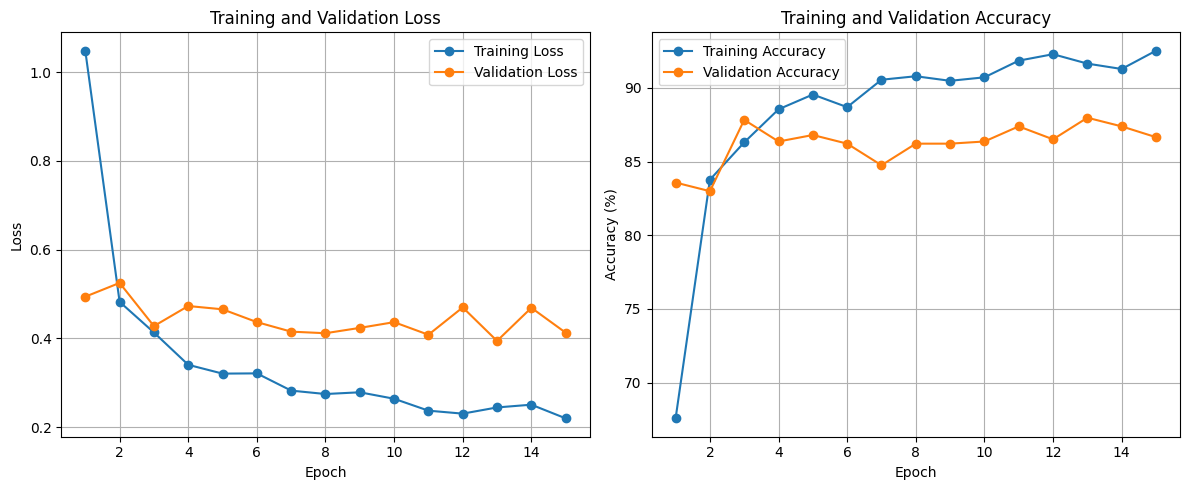

In [ ]:
# Train the model
epochs = 15
learning_rate = 1e-2

model = get_model()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs)
test_model(model, test_loader)

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

In [ ]:
# Save the model
file_name = 'test_acc_0.8604.pth'

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/COMP4471/Project/models')
torch.save(model, f'/content/drive/My Drive/COMP4471/Project/models/{file_name}')

# torch.save(model, file_name)

## Performance evaluation

In [ ]:
# Load a trained model
file_name = 'test_acc_0.8604.pth'

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/COMP4471/Project/models')
model = torch.load(f'/content/drive/My Drive/COMP4471/Project/models/{file_name}', map_location=device, weights_only=False)

# model = torch.load(file_name, map_location=device, weights_only=False)

Mounted at /content/drive


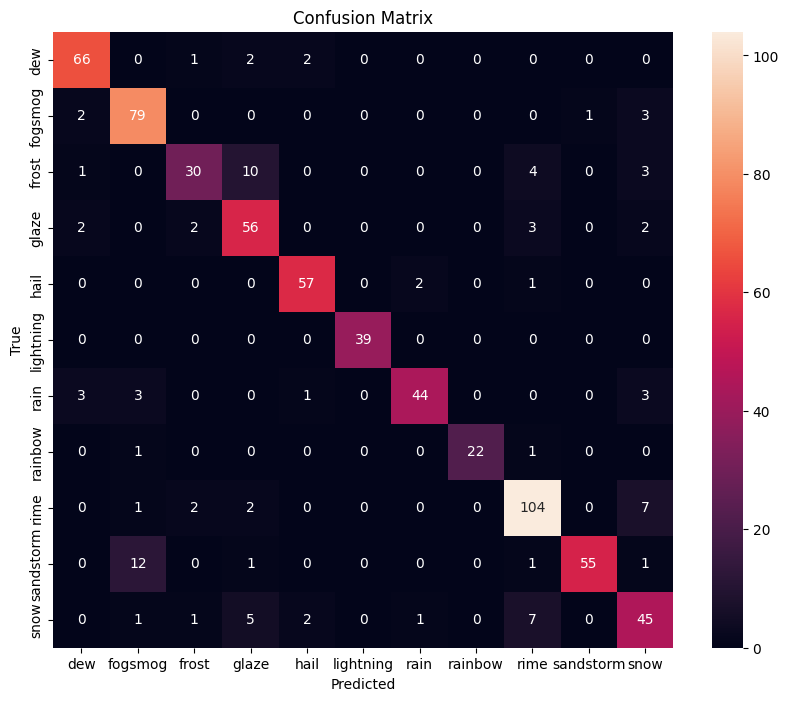

In [ ]:
labels, preds, probs = get_predictions_and_probs(model, test_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=original_dataset.classes, yticklabels=original_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Precision and Recall:
Macro Precision: 0.8797
Macro Recall: 0.8577
Weighted Precision: 0.8663
Weighted Recall: 0.8602

Per-class Metrics:
              precision    recall  f1-score   support

         dew       0.89      0.93      0.91        71
     fogsmog       0.81      0.93      0.87        85
       frost       0.83      0.62      0.71        48
       glaze       0.74      0.86      0.79        65
        hail       0.92      0.95      0.93        60
   lightning       1.00      1.00      1.00        39
        rain       0.94      0.81      0.87        54
     rainbow       1.00      0.92      0.96        24
        rime       0.86      0.90      0.88       116
   sandstorm       0.98      0.79      0.87        70
        snow       0.70      0.73      0.71        62

    accuracy                           0.86       694
   macro avg       0.88      0.86      0.86       694
weighted avg       0.87      0.86      0.86       694


AUC Scores:
AUC for dew: 0.9973
AUC for fogsmog:

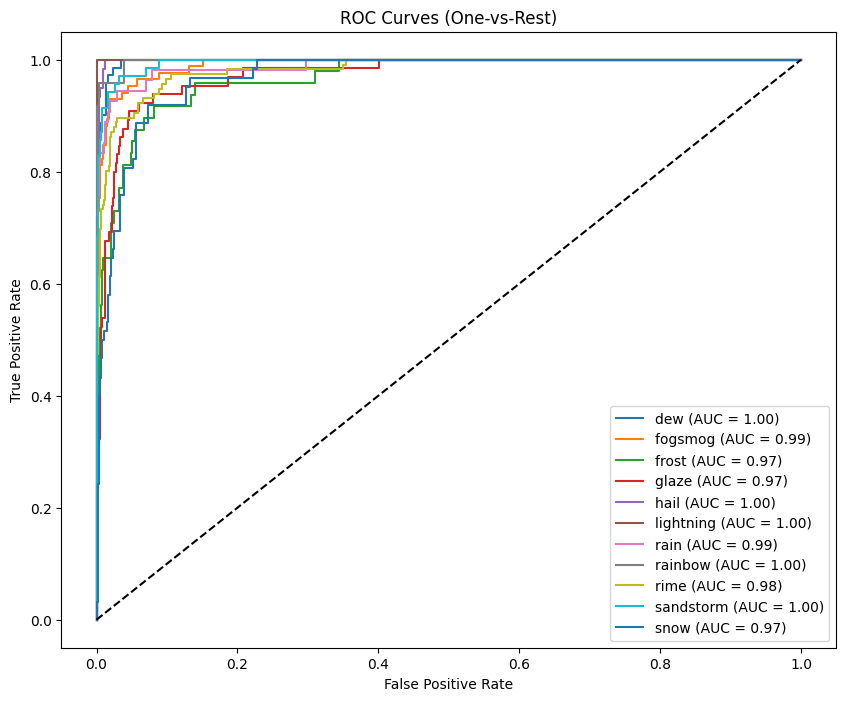

In [ ]:
# Precision and Recall
print("Precision and Recall:")
print(f"Macro Precision: {precision_score(labels, preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(labels, preds, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(labels, preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(labels, preds, average='weighted'):.4f}")
print("\nPer-class Metrics:")
print(classification_report(labels, preds, target_names=original_dataset.classes))

# AUC
labels_bin = label_binarize(labels, classes=range(num_classes))
auc_per_class = [roc_auc_score(labels_bin[:, i], probs[:, i]) for i in range(num_classes)]
macro_auc = roc_auc_score(labels_bin, probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(labels_bin.ravel(), probs.ravel())

print("\nAUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {original_dataset.classes[i]}: {auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'{original_dataset.classes[i]} (AUC = {auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

## Application

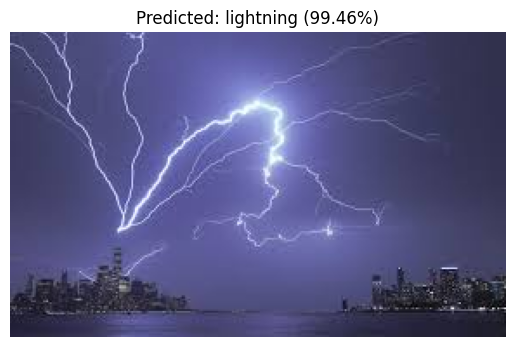

In [ ]:
image_path = '/content/' + 'lightning1.jpeg'
classes = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']

image = Image.open(image_path).convert('RGB')
image_tensor = transform_val_test(image).unsqueeze(0)
image_tensor = image_tensor.to(device)
with torch.no_grad():  # No gradients needed for inference
    output = model(image_tensor)
    prob = torch.softmax(output, dim=1)
    confidence, predicted_idx = torch.max(prob, 1)
    predicted = classes[predicted_idx.item()]
    confidence_score = confidence.item() * 100
plt.imshow(image)
plt.title(f"Predicted: {predicted} ({confidence_score:.2f}%)")
plt.axis('off')
plt.show()